In [2]:
import torch
!pip install pyro-ppl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pyro.distributions as dist
import pyro
from torch.autograd import Variable
from pyro.infer.autoguide import *
from pyro.optim import Adam
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC
from torch.distributions import constraints
from pyro import poutine

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks
     time  sunspot.year
0  1700.5           8.3
1  1701.5          18.3
2  1702.5          26.7
3  1703.5          38.3
4  1704.5          60.0


(array([16., 25., 25., 21., 10., 16., 14.,  8., 16., 13.,  9., 16.,  8.,
         7., 10., 14.,  9.,  6.,  7.,  8.,  7.,  6.,  5.,  1.,  5.,  6.,
         2.,  5.,  5.,  3.,  3.,  3.,  4.,  2.,  1.,  0.,  0.,  0.,  2.,
         1.]),
 array([  0.    ,   6.7325,  13.465 ,  20.1975,  26.93  ,  33.6625,
         40.395 ,  47.1275,  53.86  ,  60.5925,  67.325 ,  74.0575,
         80.79  ,  87.5225,  94.255 , 100.9875, 107.72  , 114.4525,
        121.185 , 127.9175, 134.65  , 141.3825, 148.115 , 154.8475,
        161.58  , 168.3125, 175.045 , 181.7775, 188.51  , 195.2425,
        201.975 , 208.7075, 215.44  , 222.1725, 228.905 , 235.6375,
        242.37  , 249.1025, 255.835 , 262.5675, 269.3   ]),
 <a list of 40 Patch objects>)

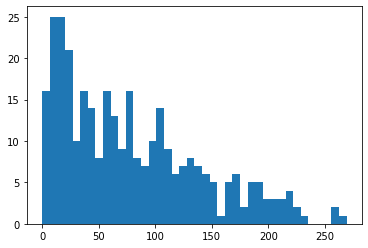

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd My\ Drive
%cd Colab\ Notebooks

df = pd.read_csv('sunspot.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
print (df.head())

plt.hist(df['sunspot.year'].values, bins=40)

In [14]:
data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32)
K = 30

def stick_breaking(beta):
    res = torch.cat([ torch.tensor([1], dtype=torch.float32), torch.cumprod((1 - beta)[:-1], dim=0)])
    return beta * res

def model(data):
    alpha0 = pyro.sample('alpha', dist.Gamma(2, .5))
    betas = []
    rates = []
    for i in range(K):
      beta = pyro.sample("beta_{}".format(i), dist.Beta(1, alpha0))
      betas.append(beta)
      lambda_ = pyro.sample("lambda_{}".format(i), dist.Uniform(0, 200))
      rates.append(lambda_)

    w = pyro.param("weights", stick_breaking(torch.tensor(betas, dtype=torch.float32)), constraint=constraints.simplex)

    for j in range(len(data)):
      z = pyro.sample("z_{}".format(j), dist.Categorical(w))
      print (w)
      print (z)
      pyro.sample("obs_{}".format(j), dist.Poisson(rates[z.item()]), obs=data[i])


nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel,
            num_samples=1000,
            warmup_steps=1000,
            num_chains=1)
mcmc.run(data)
mcmc.summary(prob=0.5)


Warmup:   0%|          | 0/2000 [00:00, ?it/s]

tensor([0.1676, 0.1116, 0.0624, 0.1709, 0.0016, 0.0598, 0.0234, 0.0316, 0.0978,
        0.0092, 0.0829, 0.0481, 0.0036, 0.0052, 0.0113, 0.0071, 0.0012, 0.0090,
        0.0015, 0.0034, 0.0148, 0.0154, 0.0051, 0.0115, 0.0213, 0.0040, 0.0058,
        0.0095, 0.0020, 0.0012], grad_fn=<DivBackward0>)
tensor(10)
tensor([0.1676, 0.1116, 0.0624, 0.1709, 0.0016, 0.0598, 0.0234, 0.0316, 0.0978,
        0.0092, 0.0829, 0.0481, 0.0036, 0.0052, 0.0113, 0.0071, 0.0012, 0.0090,
        0.0015, 0.0034, 0.0148, 0.0154, 0.0051, 0.0115, 0.0213, 0.0040, 0.0058,
        0.0095, 0.0020, 0.0012], grad_fn=<DivBackward0>)
tensor(8)
tensor([0.1676, 0.1116, 0.0624, 0.1709, 0.0016, 0.0598, 0.0234, 0.0316, 0.0978,
        0.0092, 0.0829, 0.0481, 0.0036, 0.0052, 0.0113, 0.0071, 0.0012, 0.0090,
        0.0015, 0.0034, 0.0148, 0.0154, 0.0051, 0.0115, 0.0213, 0.0040, 0.0058,
        0.0095, 0.0020, 0.0012], grad_fn=<DivBackward0>)
tensor(2)
tensor([0.1676, 0.1116, 0.0624, 0.1709, 0.0016, 0.0598, 0.0234, 0.0316, 0.0978

ValueError: ignored

In [0]:
# med = guide.median()
# print(med.values())

test = torch.tensor([0.0032402134966105223, 0.06455331295728683, 0.2762199640274048, 0.31377652287483215, 0.07324830442667007, 0.5550197958946228, 0.12213166803121567, 0.16281923651695251, 0.2476084977388382, 0.25994694232940674, 0.0049408357590436935, 0.28604158759117126, 0.15739665925502777, 0.07029961794614792, 0.23084625601768494, 0.1859404295682907, 0.21132522821426392, 0.28532591462135315, 0.08576397597789764, 0.19450387358665466, 0.2626914978027344, 0.029537536203861237, 0.01956009678542614, 0.14685307443141937, 0.10588030517101288, 0.11197519302368164, 0.021977802738547325, 0.22057555615901947, 0.13830333948135376, 0.00910981185734272])
print (stick_breaking(test))

# post = guide.get_posterior()
# print (post.__dict__)
# print( post.base_dist)
# print (post.event_dim)
# print (post.sample())

tensor([3.2402e-03, 6.4344e-02, 2.5755e-01, 2.1176e-01, 3.3922e-02, 2.3821e-01,
        2.3325e-02, 2.7297e-02, 3.4754e-02, 2.7451e-02, 3.8614e-04, 2.2244e-02,
        8.7389e-03, 3.2888e-03, 1.0040e-02, 6.2204e-03, 5.7551e-03, 6.1283e-03,
        1.3165e-03, 2.7296e-03, 2.9694e-03, 2.4618e-04, 1.5821e-04, 1.1646e-03,
        7.1633e-04, 6.7736e-04, 1.1806e-04, 1.1588e-03, 5.6634e-04, 3.2144e-05])


In [0]:


post_pmf_contribs = sp.stats.poisson.pmf(np.atleast_3d(x_plot),
                                         trace[:, np.newaxis, :])
post_pmfs = (trace['w'][:, np.newaxis, :] * post_pmf_contribs).sum(axis=-1)

post_pmf_low, post_pmf_high = np.percentile(post_pmfs, [2.5, 97.5], axis=0)

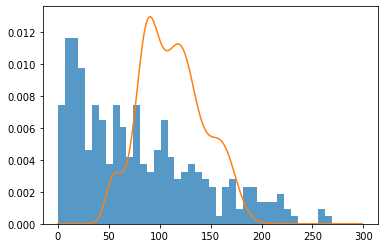

In [0]:
from scipy.stats import poisson

X = np.arange(0, 300)

beta = torch.tensor([pyro.param('auto_beta_{}'.format(i)).detach() for i in range(K)])

w = stick_breaking(beta).numpy()
w = w / w.sum()

def mop(X, weights):
  # weights = pyro.param('weights').detach().numpy()
  # rates = [pyro.param('auto_lambda_{}'.format(i)).detach().item() for i in range(len(weights) - 1)]
  rates = [pyro.param('auto_lambda_{}'.format(i)).detach().item() for i in range(K)]

  return sum( [weights[i] * poisson.pmf(X, rates[i]) for i in range(K)] )


Y = mop(X, w)
# print(Y)
plt.hist(data, bins=40, density=True, lw=0, alpha=0.75);
plt.plot(X, Y)
plt.show()


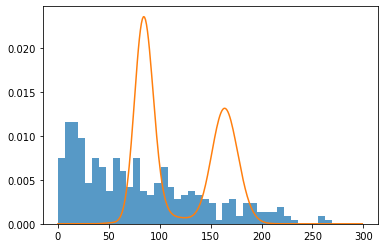

In [0]:
Y = mop(X, weights = pyro.param('weights').detach().numpy())
# print(Y)
plt.hist(data, bins=40, density=True, lw=0, alpha=0.75);
plt.plot(X, Y)
plt.show()
